In [1]:
using IPG, IPG.JuMP, SCIP
using Random, LinearAlgebra, Plots

The random instance generation procedure is based on
> Dragotto, Gabriele, and Rosario Scatamacchia. “The Zero Regrets Algorithm: Optimizing over Pure Nash Equilibria via Integer Programming.” INFORMS Journal on Computing 35, no. 5 (September 2023): 1143–60. https://doi.org/10.1287/ijoc.2022.0282.

The original can be seen in their repository: https://github.com/gdragotto/ZeroRegretsAlgorithm

In [2]:
function generate_random_instance(n::Int, m::Int, lower_bound::Int, upper_bound::Int; i_type="H")
    factor = i_type == "H" ? 0.1 : 0.01
    RQ = 5

    # Generate positive semidefinite matrix M
    M = zeros(Float64, (n*m, n*m))
    while ~isposdef(M)
        M = rand(Float64, (n*m, n*m))
        M = (M .* 2 .- 1) .* RQ  # scaling
        M = M * M'
    end

    M_max = maximum(M)
    for i in 1:n
        for j in ((i-1) * m + 1):(i * m)
            for k in (i * m + 1):(size(M, 2))
                vjk = (rand() * 2 - 1) * factor * M_max
                vjk = round(vjk, digits=1)
                M[j, k] += vjk
                M[k, j] -= vjk
            end
        end
    end

    # build players
    players = Vector{Player{QuadraticPayoff}}()
    for p in 1:n
        # build payoff
        Qp = Vector{Matrix{Float64}}()
        for k in 1:n
            push!(Qp, M[((p-1) * m + 1):(p * m), ((k-1) * m + 1):(k * m)])
        end

        cp = rand(-RQ:RQ, m)
        Πp = QuadraticPayoff(cp, Qp, p)

        # build strategy space
        Xp = Model()
        @variable(Xp, lower_bound <= x[1:m] <= upper_bound, Int)

        push!(players, Player(Xp, x, Πp, p))
    end

    return players
end

generate_random_instance (generic function with 1 method)

In [3]:
players = generate_random_instance(2, 1, -500, 500)

# IPG.initialize_strategies = IPG.initialize_strategies_player_alone
IPG.initialize_strategies = IPG.initialize_strategies_feasibility

Σ, payoff_improvements = IPG.SGM(players, SCIP.Optimizer, max_iter=25, verbose=true)

Game initialized with strategies: [[[500.0]], [[500.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[500.0]])]
Deviation found for player 2 with payoff improvement 666429.5263189927
New strategy added for player 2: [282.0]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[282.0]])]
Deviation found for player 1 with payoff improvement 1.1290501571967548e6
New strategy added for player 1: [170.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[170.0]]), DiscreteMixedStrategy([1.0], [[282.0]])]
Deviation found for player 2 with payoff improvement 486184.7406539875
New strategy added for player 2: [96.0]
Iter 4
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[170.0]]), DiscreteMixedStrategy([1.0], [[96.0]])]
Deviation found for player 1 with 

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[500.0]])], [DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[282.0]])], [DiscreteMixedStrategy([1.0], [[170.0]]), DiscreteMixedStrategy([1.0], [[282.0]])], [DiscreteMixedStrategy([1.0], [[170.0]]), DiscreteMixedStrategy([1.0], [[96.0]])], [DiscreteMixedStrategy([1.0], [[58.0]]), DiscreteMixedStrategy([1.0], [[96.0]])], [DiscreteMixedStrategy([1.0], [[58.0]]), DiscreteMixedStrategy([1.0], [[33.0]])], [DiscreteMixedStrategy([1.0], [[20.0]]), DiscreteMixedStrategy([1.0], [[33.0]])], [DiscreteMixedStrategy([1.0], [[20.0]]), DiscreteMixedStrategy([1.0], [[11.0]])], [DiscreteMixedStrategy([1.0], [[6.999999999999995]]), DiscreteMixedStrategy([1.0], [[11.0]])], [DiscreteMixedStrategy([1.0], [[6.999999999999995]]), DiscreteMixedStrategy([1.0], [[3.99999999999995]])], [DiscreteMixedStrategy([1.0], [[3.0]]), DiscreteMixedStrategy([1.0], [[3.99999999999995]])], [DiscreteMi

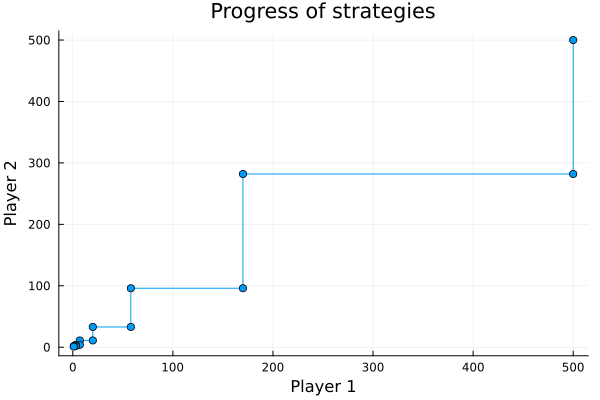

In [4]:
p1_strategies = [expected_value(identity, σk[1])[1] for σk in Σ]
p2_strategies = [expected_value(identity, σk[2])[1] for σk in Σ]

plot(p1_strategies, p2_strategies, marker=:c, title="Progress of strategies", legend=false)
xlabel!("Player 1")
ylabel!("Player 2")

In [5]:
players = generate_random_instance(3, 3, -50, 50)

# IPG.initialize_strategies = IPG.initialize_strategies_player_alone
IPG.initialize_strategies = IPG.initialize_strategies_feasibility

Σ, payoff_improvements = IPG.SGM(players, SCIP.Optimizer, max_iter=25, verbose=true)

Game initialized with strategies: [[[50.0, 50.0, 50.0]], [[50.0, 50.0, 50.0]], [[50.0, 50.0, 50.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([0.9999999999999999], [[50.0, 50.0, 50.0]])]
Deviation found for player 2 with payoff improvement 525919.4166945966
New strategy added for player 2: [-50.0, -50.0, 26.999999999999726]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-50.0, -50.0, 26.999999999999726]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]])]
Deviation found for player 3 with payoff improvement 87345.25592986915
New strategy added for player 3: [9.000000000000744, 50.0, 50.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-50.0, -50.0, 2

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([0.9999999999999999], [[50.0, 50.0, 50.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-50.0, -50.0, 26.999999999999726]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-50.0, -50.0, 26.999999999999726]]), DiscreteMixedStrategy([1.0], [[9.000000000000744, 50.0, 50.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 6.0, -20.0]]), DiscreteMixedStrategy([1.0], [[-50.0, -50.0, 26.999999999999726]]), DiscreteMixedStrategy([1.0], [[9.000000000000744, 50.0, 50.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 6.0, -20.0]]), DiscreteMixedStrategy([1.0], [[-50.0, -50.0, 26.0]]), DiscreteMixedStrategy([1.0], [[9.000000000000744, 50.0, 50.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 6.0, -20.0]]), DiscreteMixedStrategy(